In [111]:
import kagglehub
import shutil
import wave
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy.signal import resample, spectrogram
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from scipy.ndimage import zoom
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

In [80]:
import tensorflow as tf

# List available GPUs
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("GPU available")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("GPU not available")
    

GPU not available


In [79]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
# Download latest version
path = kagglehub.dataset_download("shreyj1729/best-of-watkins-marine-mammal-sound-database")

print("Path to dataset files:", path)

Path to dataset files: /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3


In [8]:
spectrogram_folder = "/Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/spectrograms"
modified_data_folder = "/Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/modifieddata"
problematic_folder = "/Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/badfiles"
data_path = "/Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/data"
target_sr = 16000

In [9]:
#Used to get data into same directory
#shutil.move(path, "/Users/miku/Documents/GitHub/Marine_Mammal_Classification_By_Sound")
#path = 

path = "/Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/data"

In [5]:
for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
    
    #Skip if it's not a directory
    if not os.path.isdir(folder_path):
        continue
    
    #Count the number of files in the current directory
    num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    
    print(f"Folder: {folder}, Number of files: {num_files}")


Folder: GraySeal, Number of files: 7
Folder: LongBeaked(Pacific)CommonDolphin, Number of files: 69
Folder: PantropicalSpottedDolphin, Number of files: 1033
Folder: RossSeal, Number of files: 149
Folder: Grampus_Risso'sDolphin, Number of files: 359
Folder: White_beakedDolphin, Number of files: 196
Folder: FinlessPorpoise, Number of files: 2
Folder: WeddellSeal, Number of files: 133
Folder: Short_Finned(Pacific)PilotWhale, Number of files: 618
Folder: NewZealandFurSeal, Number of files: 2
Folder: SpottedSeal, Number of files: 22
Folder: SouthernRightWhale, Number of files: 49
Folder: LeopardSeal, Number of files: 51
Folder: IrawaddyDolphin, Number of files: 5
Folder: MelonHeadedWhale, Number of files: 161
Folder: FalseKillerWhale, Number of files: 508
Folder: MinkeWhale, Number of files: 24
Folder: Commerson'sDolphin, Number of files: 1
Folder: StellerSeaLion, Number of files: 6
Folder: ClymeneDolphin, Number of files: 327
Folder: SpinnerDolphin, Number of files: 524
Folder: GrayWhale, N

In [6]:
def move_problematic_file(file_path, problematic_folder):
    try:
        os.makedirs(problematic_folder, exist_ok=True)
        shutil.move(file_path, os.path.join(problematic_folder, os.path.basename(file_path)))
        print(f"Moved {file_path} to {problematic_folder}")
    except Exception as e:
        print(f"Error moving file {file_path}: {e}")

In [10]:
def process_audio_file(file_path, target_length_seconds=5, output_folder=modified_data_folder, problematic_folder=problematic_folder):
    try:
        # Read the WAV file
        sample_rate, data = wavfile.read(file_path)
        
        # Calculate the target number of samples (5 seconds)
        target_samples = target_length_seconds * sample_rate
        
        # Trim or pad the audio data
        if len(data) > target_samples:
            # Trim to 5 seconds
            data = data[:target_samples]
        elif len(data) < target_samples:
            # Pad with zeros (silence) if less than 5 seconds
            padding = target_samples - len(data)
            data = np.pad(data, (0, padding), mode='constant')

        # Save the modified file to the output folder (don't overwrite the original)
        output_file = os.path.join(output_folder, os.path.basename(file_path))
        wavfile.write(output_file, sample_rate, data)
        print(f"Processed {file_path}, saved to {output_file}")

    except ValueError as e:
        print(f"Error processing {file_path}: {e}")
        move_problematic_file(file_path, problematic_folder)

In [11]:
def print_audio_length(filename):
    try:
        sample_rate, data = wavfile.read(filename)
        audio_length = len(data) / sample_rate
        return audio_length
    except ValueError as e:
        print(f"Error processing {filename}: {e}")
        return None

In [12]:
def get_wav_channels(filename):
    with wave.open(filename, 'r') as wav_file:
        return wav_file.getnchannels()

In [13]:
def resample_audio(audio_data, original_sr, target_sr=16000):
    num_samples = int(len(audio_data) * float(target_sr) / original_sr)
    return resample(audio_data, num_samples)

In [14]:
def save_spectrogram(filename, output_base_folder, target_sr=16000):
    try:
        sample_rate, data = wavfile.read(filename)
        
        if sample_rate != target_sr:
            data = resample_audio(data, sample_rate, target_sr)
            sample_rate = target_sr
        
        f, t, Sxx = spectrogram(data, sample_rate)
        
        # Get the relative path of the animal folder from the original file
        animal_folder = os.path.basename(os.path.dirname(filename))
        
        # Define the output folder for this animal, preserving the directory structure
        animal_output_folder = os.path.join(output_base_folder, animal_folder)
        
        os.makedirs(animal_output_folder, exist_ok=True)
        
        # Define the output path for the spectrogram data file
        output_filename = os.path.join(animal_output_folder, os.path.basename(filename).replace('.wav', '_spectrogram.npy'))
        
        # Save the spectrogram as a NumPy array
        np.save(output_filename, Sxx)
        print(f"Saved spectrogram data for {filename} to {output_filename}")
    except ValueError as e:
        print(f"Error processing {filename}: {e}")

In [15]:
def process_audio_data(data_path, output_folder=modified_data_folder, target_sr=16000):
    one_channel_count = 0
    multi_channel_count = 0

    for folder in os.listdir(data_path):
        folder_path = os.path.join(data_path, folder)
        
        if not os.path.isdir(folder_path):
            continue
        
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            
            if not file.endswith('.wav'):
                print("Not wav:", file)
                continue

            sample_rate, data = wavfile.read(file_path)

            # Calculate the length of the audio in seconds
            audio_length = len(data) / sample_rate
            
            # Skip files longer than 5 seconds
            if audio_length > 5:
                print(f"Skipping file {file} as it is longer than 5 seconds.")
                continue

            num_samples_5_sec = int(sample_rate * 5)
            data_first_5_sec = data[:num_samples_5_sec]

            num_channels = get_wav_channels(file_path)
            
            # Process single-channel and multi-channel files
            if num_channels == 1:
                one_channel_count += 1
                save_spectrogram(file_path, spectrogram_folder, target_sr)
                process_audio_file(file_path, target_length_seconds=5, output_folder=modified_data_folder)
            else:
                multi_channel_count += 1
                save_spectrogram(file_path, spectrogram_folder, target_sr)
                process_audio_file(file_path, target_length_seconds=5, output_folder=modified_data_folder)
                
    print(f"Number of files with 1 channel: {one_channel_count}")
    print(f"Number of files with more than 1 channel: {multi_channel_count}")

In [18]:
os.makedirs(modified_data_folder, exist_ok=True)
os.makedirs(spectrogram_folder, exist_ok=True)
os.makedirs(problematic_folder, exist_ok=True)

In [19]:
process_audio_data(data_path, output_folder=modified_data_folder, target_sr=target_sr)

Saved spectrogram data for /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/data/GraySeal/63001007.wav to /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/spectrograms/GraySeal/63001007_spectrogram.npy
Processed /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/data/GraySeal/63001007.wav, saved to /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/modifieddata/63001007.wav
Saved spectrogram data for /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/data/GraySeal/63001006.wav to /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/spectrograms/GraySeal/63001006_spectrogram.npy
Processed /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-

/var/folders/_n/zqwvc56j1m5519qx4zmzwmtm0000gn/T/ipykernel_34294/2841073615.py:18: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read(file_path)
/var/folders/_n/zqwvc56j1m5519qx4zmzwmtm0000gn/T/ipykernel_34294/253302038.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read(filename)
/var/folders/_n/zqwvc56j1m5519qx4zmzwmtm0000gn/T/ipykernel_34294/2169596419.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read(file_path)


Saved spectrogram data for /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/data/RossSeal/6609000Z.wav to /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/spectrograms/RossSeal/6609000Z_spectrogram.npy
Processed /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/data/RossSeal/6609000Z.wav, saved to /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/modifieddata/6609000Z.wav
Saved spectrogram data for /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/data/RossSeal/6608900S.wav to /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/spectrograms/RossSeal/6608900S_spectrogram.npy
Processed /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-

/var/folders/_n/zqwvc56j1m5519qx4zmzwmtm0000gn/T/ipykernel_34294/2841073615.py:18: WavFileWarning: Reached EOF prematurely; finished at 1105452 bytes, expected 1236740 bytes from header.
  sample_rate, data = wavfile.read(file_path)


Saved spectrogram data for /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/data/WeddellSeal/6405500M.wav to /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/spectrograms/WeddellSeal/6405500M_spectrogram.npy
Processed /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/data/WeddellSeal/6405500M.wav, saved to /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/modifieddata/6405500M.wav
Skipping file 64040002.wav as it is longer than 5 seconds.
Saved spectrogram data for /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/data/WeddellSeal/64055009.wav to /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/spectrograms/WeddellSeal/64055009_spectrogram.npy
Processed /User

/var/folders/_n/zqwvc56j1m5519qx4zmzwmtm0000gn/T/ipykernel_34294/2841073615.py:18: WavFileWarning: Reached EOF prematurely; finished at 194620 bytes, expected 199808 bytes from header.
  sample_rate, data = wavfile.read(file_path)


Saved spectrogram data for /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/data/BowheadWhale/8800601S.wav to /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/spectrograms/BowheadWhale/8800601S_spectrogram.npy
Processed /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/data/BowheadWhale/8800601S.wav, saved to /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/modifieddata/8800601S.wav
Saved spectrogram data for /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/data/BowheadWhale/8800602H.wav to /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/spectrograms/BowheadWhale/8800602H_spectrogram.npy
Processed /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-wa

/var/folders/_n/zqwvc56j1m5519qx4zmzwmtm0000gn/T/ipykernel_34294/2841073615.py:18: WavFileWarning: Reached EOF prematurely; finished at 32492 bytes, expected 37992 bytes from header.
  sample_rate, data = wavfile.read(file_path)
/var/folders/_n/zqwvc56j1m5519qx4zmzwmtm0000gn/T/ipykernel_34294/253302038.py:3: WavFileWarning: Reached EOF prematurely; finished at 32492 bytes, expected 37992 bytes from header.
  sample_rate, data = wavfile.read(filename)
/var/folders/_n/zqwvc56j1m5519qx4zmzwmtm0000gn/T/ipykernel_34294/2169596419.py:4: WavFileWarning: Reached EOF prematurely; finished at 32492 bytes, expected 37992 bytes from header.
  sample_rate, data = wavfile.read(file_path)
/var/folders/_n/zqwvc56j1m5519qx4zmzwmtm0000gn/T/ipykernel_34294/2841073615.py:18: WavFileWarning: Reached EOF prematurely; finished at 32836 bytes, expected 40084 bytes from header.
  sample_rate, data = wavfile.read(file_path)
/var/folders/_n/zqwvc56j1m5519qx4zmzwmtm0000gn/T/ipykernel_34294/253302038.py:3: WavFile

Skipping file 6301901N.wav as it is longer than 5 seconds.
Skipping file 63019018.wav as it is longer than 5 seconds.
Skipping file 63019019.wav as it is longer than 5 seconds.
Skipping file 6301901O.wav as it is longer than 5 seconds.
Saved spectrogram data for /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/data/HumpbackWhale/6301900K.wav to /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/spectrograms/HumpbackWhale/6301900K_spectrogram.npy
Processed /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/data/HumpbackWhale/6301900K.wav, saved to /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/modifieddata/6301900K.wav
Skipping file 92201001.wav as it is longer than 5 seconds.
Saved spectrogram data for /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-m

/var/folders/_n/zqwvc56j1m5519qx4zmzwmtm0000gn/T/ipykernel_34294/2841073615.py:18: WavFileWarning: Reached EOF prematurely; finished at 49604 bytes, expected 55944 bytes from header.
  sample_rate, data = wavfile.read(file_path)
/var/folders/_n/zqwvc56j1m5519qx4zmzwmtm0000gn/T/ipykernel_34294/253302038.py:3: WavFileWarning: Reached EOF prematurely; finished at 49604 bytes, expected 55944 bytes from header.
  sample_rate, data = wavfile.read(filename)
/var/folders/_n/zqwvc56j1m5519qx4zmzwmtm0000gn/T/ipykernel_34294/2169596419.py:4: WavFileWarning: Reached EOF prematurely; finished at 49604 bytes, expected 55944 bytes from header.
  sample_rate, data = wavfile.read(file_path)
/var/folders/_n/zqwvc56j1m5519qx4zmzwmtm0000gn/T/ipykernel_34294/2841073615.py:18: WavFileWarning: Reached EOF prematurely; finished at 32340 bytes, expected 33428 bytes from header.
  sample_rate, data = wavfile.read(file_path)
/var/folders/_n/zqwvc56j1m5519qx4zmzwmtm0000gn/T/ipykernel_34294/253302038.py:3: WavFile

Processed /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/data/HumpbackWhale/61043001.wav, saved to /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/modifieddata/61043001.wav
Saved spectrogram data for /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/data/HumpbackWhale/9220100L.wav to /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/spectrograms/HumpbackWhale/9220100L_spectrogram.npy
Processed /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/data/HumpbackWhale/9220100L.wav, saved to /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/modifieddata/9220100L.wav
Skipping file 6301900W.wav as it is longer than 5 seconds.
Saved spectrogram data for /Users/miku/.c

/var/folders/_n/zqwvc56j1m5519qx4zmzwmtm0000gn/T/ipykernel_34294/2841073615.py:18: WavFileWarning: Reached EOF prematurely; finished at 32836 bytes, expected 36220 bytes from header.
  sample_rate, data = wavfile.read(file_path)
/var/folders/_n/zqwvc56j1m5519qx4zmzwmtm0000gn/T/ipykernel_34294/253302038.py:3: WavFileWarning: Reached EOF prematurely; finished at 32836 bytes, expected 36220 bytes from header.
  sample_rate, data = wavfile.read(filename)
/var/folders/_n/zqwvc56j1m5519qx4zmzwmtm0000gn/T/ipykernel_34294/2169596419.py:4: WavFileWarning: Reached EOF prematurely; finished at 32836 bytes, expected 36220 bytes from header.
  sample_rate, data = wavfile.read(file_path)


Saved spectrogram data for /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/data/HumpbackWhale/54018002.wav to /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/spectrograms/HumpbackWhale/54018002_spectrogram.npy
Processed /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/data/HumpbackWhale/54018002.wav, saved to /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/modifieddata/54018002.wav
Skipping file 5401800S.wav as it is longer than 5 seconds.
Saved spectrogram data for /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/data/HumpbackWhale/86008053.wav to /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/spectrograms/HumpbackWhale/86008053_spectrogram.npy
Proce

/var/folders/_n/zqwvc56j1m5519qx4zmzwmtm0000gn/T/ipykernel_34294/2841073615.py:18: WavFileWarning: Reached EOF prematurely; finished at 36972 bytes, expected 39044 bytes from header.
  sample_rate, data = wavfile.read(file_path)
/var/folders/_n/zqwvc56j1m5519qx4zmzwmtm0000gn/T/ipykernel_34294/253302038.py:3: WavFileWarning: Reached EOF prematurely; finished at 36972 bytes, expected 39044 bytes from header.
  sample_rate, data = wavfile.read(filename)
/var/folders/_n/zqwvc56j1m5519qx4zmzwmtm0000gn/T/ipykernel_34294/2169596419.py:4: WavFileWarning: Reached EOF prematurely; finished at 36972 bytes, expected 39044 bytes from header.
  sample_rate, data = wavfile.read(file_path)
/var/folders/_n/zqwvc56j1m5519qx4zmzwmtm0000gn/T/ipykernel_34294/2841073615.py:18: WavFileWarning: Reached EOF prematurely; finished at 43172 bytes, expected 47702 bytes from header.
  sample_rate, data = wavfile.read(file_path)
/var/folders/_n/zqwvc56j1m5519qx4zmzwmtm0000gn/T/ipykernel_34294/253302038.py:3: WavFile

Saved spectrogram data for /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/data/HumpbackWhale/5801800D.wav to /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/spectrograms/HumpbackWhale/5801800D_spectrogram.npy
Processed /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/data/HumpbackWhale/5801800D.wav, saved to /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/modifieddata/5801800D.wav
Saved spectrogram data for /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/data/HumpbackWhale/58018016.wav to /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/spectrograms/HumpbackWhale/58018016_spectrogram.npy
Processed /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-

/var/folders/_n/zqwvc56j1m5519qx4zmzwmtm0000gn/T/ipykernel_34294/2841073615.py:18: WavFileWarning: Reached EOF prematurely; finished at 60972 bytes, expected 154184 bytes from header.
  sample_rate, data = wavfile.read(file_path)
/var/folders/_n/zqwvc56j1m5519qx4zmzwmtm0000gn/T/ipykernel_34294/253302038.py:3: WavFileWarning: Reached EOF prematurely; finished at 60972 bytes, expected 154184 bytes from header.
  sample_rate, data = wavfile.read(filename)
/var/folders/_n/zqwvc56j1m5519qx4zmzwmtm0000gn/T/ipykernel_34294/2169596419.py:4: WavFileWarning: Reached EOF prematurely; finished at 60972 bytes, expected 154184 bytes from header.
  sample_rate, data = wavfile.read(file_path)


Saved spectrogram data for /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/data/KillerWhale/9230402J.wav to /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/spectrograms/KillerWhale/9230402J_spectrogram.npy
Processed /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/data/KillerWhale/9230402J.wav, saved to /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/modifieddata/9230402J.wav
Saved spectrogram data for /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/data/KillerWhale/6001200T.wav to /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/spectrograms/KillerWhale/6001200T_spectrogram.npy
Processed /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins

/var/folders/_n/zqwvc56j1m5519qx4zmzwmtm0000gn/T/ipykernel_34294/2841073615.py:18: WavFileWarning: Reached EOF prematurely; finished at 65068 bytes, expected 270208 bytes from header.
  sample_rate, data = wavfile.read(file_path)
/var/folders/_n/zqwvc56j1m5519qx4zmzwmtm0000gn/T/ipykernel_34294/253302038.py:3: WavFileWarning: Reached EOF prematurely; finished at 65068 bytes, expected 270208 bytes from header.
  sample_rate, data = wavfile.read(filename)
/var/folders/_n/zqwvc56j1m5519qx4zmzwmtm0000gn/T/ipykernel_34294/2169596419.py:4: WavFileWarning: Reached EOF prematurely; finished at 65068 bytes, expected 270208 bytes from header.
  sample_rate, data = wavfile.read(file_path)


Saved spectrogram data for /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/data/SpermWhale/6602600G.wav to /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/spectrograms/SpermWhale/6602600G_spectrogram.npy
Processed /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/data/SpermWhale/6602600G.wav, saved to /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/modifieddata/6602600G.wav
Saved spectrogram data for /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/data/SpermWhale/85002005.wav to /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/spectrograms/SpermWhale/85002005_spectrogram.npy
Processed /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-mari

/var/folders/_n/zqwvc56j1m5519qx4zmzwmtm0000gn/T/ipykernel_34294/2841073615.py:18: WavFileWarning: Reached EOF prematurely; finished at 383532 bytes, expected 693034 bytes from header.
  sample_rate, data = wavfile.read(file_path)
/var/folders/_n/zqwvc56j1m5519qx4zmzwmtm0000gn/T/ipykernel_34294/253302038.py:3: WavFileWarning: Reached EOF prematurely; finished at 383532 bytes, expected 693034 bytes from header.
  sample_rate, data = wavfile.read(filename)
/var/folders/_n/zqwvc56j1m5519qx4zmzwmtm0000gn/T/ipykernel_34294/2169596419.py:4: WavFileWarning: Reached EOF prematurely; finished at 383532 bytes, expected 693034 bytes from header.
  sample_rate, data = wavfile.read(file_path)


Saved spectrogram data for /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/data/SpermWhale/75005020.wav to /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/spectrograms/SpermWhale/75005020_spectrogram.npy
Processed /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/data/SpermWhale/75005020.wav, saved to /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/modifieddata/75005020.wav
Saved spectrogram data for /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/data/SpermWhale/8103800K.wav to /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-marine-mammal-sound-database/versions/3/spectrograms/SpermWhale/8103800K_spectrogram.npy
Processed /Users/miku/.cache/kagglehub/datasets/shreyj1729/best-of-watkins-mari

In [115]:
def load_spectrogram_data(spectrogram_folder, target_shape=(128, 128)):
    spectrograms = []
    labels = []
    
    for animal_folder in os.listdir(spectrogram_folder):
        animal_folder_path = os.path.join(spectrogram_folder, animal_folder)
        
        if not os.path.isdir(animal_folder_path):
            continue
        
        for file in os.listdir(animal_folder_path):
            if file.endswith('.npy'):
                file_path = os.path.join(animal_folder_path, file)
                spectrogram = np.load(file_path)
                
                # Resize spectrogram to the target shape
                spectrogram_resized = zoom(spectrogram, (target_shape[0] / spectrogram.shape[0], target_shape[1] / spectrogram.shape[1]), order=3)
                
                # Ensure spectrogram has the right dimensions (e.g., 2D: time x frequency)
                spectrograms.append(spectrogram_resized)
                labels.append(animal_folder)
    
    # Convert lists to numpy arrays
    spectrograms = np.array(spectrograms)
    labels = np.array(labels)
    
    return spectrograms, labels

# Load the spectrogram data with the resized shape
spectrograms, labels = load_spectrogram_data(spectrogram_folder, target_shape=(128, 128))

# Check the shapes
print(f"Spectrograms shape: {spectrograms.shape}")
print(f"Labels shape: {labels.shape}")


Spectrograms shape: (13712, 128, 128)
Labels shape: (13712,)


In [116]:
# Normalize spectrograms to range [0, 1]
spectrograms_normalized = spectrograms.astype('float32') / np.max(spectrograms)

# Encode the labels (species) into integer encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Check the processed data shapes
print(f"Spectrograms normalized shape: {spectrograms_normalized.shape}")
print(f"Labels encoded shape: {labels_encoded.shape}")


Spectrograms normalized shape: (13712, 128, 128)
Labels encoded shape: (13712,)


In [117]:
# Split data into training and testing sets using integer-encoded labels
X_train, X_test, y_train, y_test = train_test_split(
    spectrograms_normalized, labels_encoded, test_size=0.2, random_state=42
)

# Check the shapes of the split data
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (10969, 128, 128)
X_test shape: (2743, 128, 128)
y_train shape: (10969,)
y_test shape: (2743,)


In [118]:
# Add a channel dimension for grayscale images
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)


In [119]:
def build_cnn_model(input_shape, num_classes):
    model = models.Sequential(
        [
            layers.InputLayer(input_shape=input_shape),

            # Convolutional layers
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2)),

            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2)),

            layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2)),

            # Flatten the output from the convolutional layers
            layers.Flatten(),

            # Fully connected layer
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.3),

            # Output layer
            layers.Dense(num_classes, activation='softmax')
        ]
    )
    return model

In [121]:

# Build model
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

model = build_cnn_model(input_shape, num_classes)

learning_rate = 0.001  # You can adjust this value as needed
optimizer = Adam(learning_rate=learning_rate)

# Compile model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


IndexError: tuple index out of range

In [109]:
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitor validation loss
    patience=5,               # Stop after 5 epochs with no improvement
    restore_best_weights=True # Restore the best model weights
)

In [113]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print(class_weight_dict)

TypeError: unhashable type: 'numpy.ndarray'

In [88]:
history = model.fit(
    X_train, y_train,
    epochs=1000,                # Set a higher max epoch; training will stop early if needed
    batch_size=32,            # Batch size for training
    validation_split=0.2,     # Use 20% of training data for validation
    callbacks=[early_stopping], # Add the callback here
    class_weight=class_weight_dict
)

Epoch 1/200
275/275 ━━━━━━━━━━━━━━━━━━━━ 48s 169ms/step - accuracy: 0.1709 - loss: 3.2852 - val_accuracy: 0.2083 - val_loss: 2.9900
Epoch 2/200
275/275 ━━━━━━━━━━━━━━━━━━━━ 43s 155ms/step - accuracy: 0.2213 - loss: 2.9336 - val_accuracy: 0.2229 - val_loss: 2.9141
Epoch 3/200
275/275 ━━━━━━━━━━━━━━━━━━━━ 40s 145ms/step - accuracy: 0.2382 - loss: 2.8017 - val_accuracy: 0.1864 - val_loss: 2.8308
Epoch 4/200
275/275 ━━━━━━━━━━━━━━━━━━━━ 40s 145ms/step - accuracy: 0.2652 - loss: 2.6582 - val_accuracy: 0.2890 - val_loss: 2.5999
Epoch 5/200
275/275 ━━━━━━━━━━━━━━━━━━━━ 40s 144ms/step - accuracy: 0.3047 - loss: 2.4383 - val_accuracy: 0.2242 - val_loss: 2.6206
Epoch 6/200
275/275 ━━━━━━━━━━━━━━━━━━━━ 39s 142ms/step - accuracy: 0.3482 - loss: 2.2629 - val_accuracy: 0.3751 - val_loss: 2.2309
Epoch 7/200
275/275 ━━━━━━━━━━━━━━━━━━━━ 39s 142ms/step - accuracy: 0.3990 - loss: 2.0746 - val_accuracy: 0.4116 - val_loss: 2.1080
Epoch 8/200
275/275 ━━━━━━━━━━━━━━━━━━━━ 39s 140ms/step - accuracy: 0.4572 -

In [89]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.5549 - loss: 1.8518
Test Loss: 1.9167677164077759
Test Accuracy: 0.549763023853302


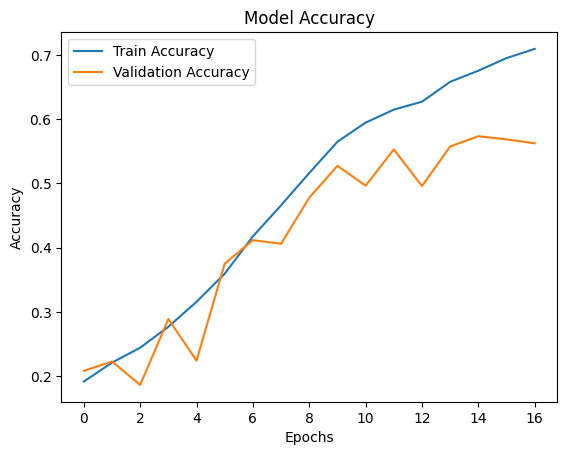

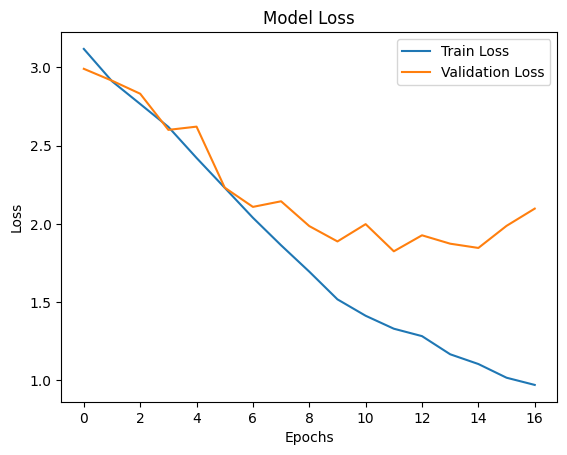

In [90]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [91]:
# Make predictions on the test set
predictions = model.predict(X_test)

# Convert predictions from one-hot encoded probabilities to class indices
predicted_classes = predictions.argmax(axis=1)
actual_classes = y_test.argmax(axis=1)

# Compare the predictions with the actual labels
print(f"Predicted Classes: {predicted_classes[:10]}")
print(f"Actual Classes: {actual_classes[:10]}")


86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step
Predicted Classes: [26 44 14 26 29  3 26 44 26 47]
Actual Classes: [26 12  3 43 41 49 35  8 26 47]


In [96]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

# Function to Plot confusion matrix
def confMat(model, X_test, y_test):
    plt.figure(figsize=(15, 5))

    # Predict the test set images
    predict_x = model.predict(X_test)
    # Get the predicted labels (probabilities to class labels)
    y_pred = np.argmax(predict_x, axis=1)

    # Convert one-hot encoded y_test to labels (indices of the species)
    y_test_labels = np.argmax(y_test, axis=1)

    # Extract categories automatically based on unique values in y_train or y_test
    categories = np.unique(y_test_labels)

    # Compute confusion matrix
    cm = confusion_matrix(y_test_labels, y_pred)

    # Create a DataFrame for the confusion matrix for better visualization
    df_cm = pd.DataFrame(cm, index=categories, columns=categories)

    # Plot confusion matrix
    plt.title("Confusion Matrix\n")
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

    return cm


86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step


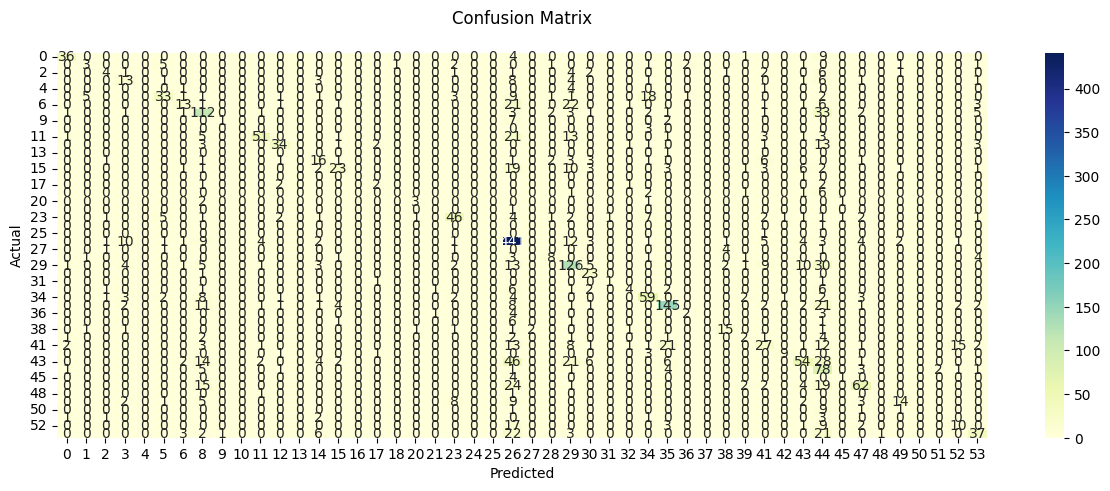

In [97]:
cm = confMat(model, X_test, y_test)
